In [1]:
# Sample API
import mae6225
#import simulation
mae6225.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 20, 20
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

Re   = 1000
dt   = 0.01
tmax = 10.

# Define cell-centered variable names
center_vars = ['pres', 'divp', 'divc','asol','eror']
face_vars   = ['velc', 'hvar','asol','eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 1.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = mae6225.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = mae6225.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = mae6225.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

In [3]:
t  = 0.0
nt = 0

while(t<=tmax):
    
    # Calculate predicted velocity: u* = dt*H(u^n)
    mae6225.ins.predictor(gridx, gridy, 'velc', 'hvar', Re, dt)
    
    # Calculate RHS for the pressure Poission solver div(u)/dt
    mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divp', ifac=dt)
    
    # Solve the pressure Poisson equation 
    ites, res = mae6225.poisson.solve_jacobi(gridc, 'pres', 'divp',
                                         maxiter=10000, tol=1e-9)
    
    # Calculate corrected velocity u^n+1 = u* - dt * grad(P) 
    mae6225.ins.corrector(gridc, gridx, gridy, 'velc', 'pres', dt)
    
    # Calculate divergence of the corrected velocity to display stats
    mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divc')
    
    # Calculate stats
    ins_stats = mae6225.ins.stats(gridc, gridx, gridy, 'velc', 'pres', 'divc')
    
    # Display stats
    if(nt%100==0): mae6225.io.display_stats(t,ites,res,ins_stats)   
    
    t  = t+dt
    nt = nt+1
    

-----Time = 0.0-------
Number of poisson iterations: 1
Final poisson residual residual: 0.0
Max, Min, U: 2.0 0.0
Max, Min, V: 0.0 0.0
Max, Min, P: 0.0 0.0
Max, Min, DIV: 0.0 0.0


-----Time = 1.0000000000000007-------
Number of poisson iterations: 971
Final poisson residual residual: 9.946931433733138e-10
Max, Min, U: 2.0 -0.09208914403655512
Max, Min, V: 0.2635477402466625 -0.2635477402466625
Max, Min, P: 0.13957676885082151 -0.020426858165280497
Max, Min, DIV: 2.6160867250268893e-08 -2.5930029859400072e-08


-----Time = 2.0000000000000013-------
Number of poisson iterations: 757
Final poisson residual residual: 9.977299268516562e-10
Max, Min, U: 2.0 -0.1293727345315031
Max, Min, V: 0.36581570864712404 -0.36581570864712404
Max, Min, P: 0.21579596113902486 -0.08258246068385855
Max, Min, DIV: 3.017478800160234e-08 -2.928462787543662e-08


-----Time = 2.99999999999998-------
Number of poisson iterations: 603
Final poisson residual residual: 9.959279277171875e-10
Max, Min, U: 2.0 -0.13425

KeyboardInterrupt: 

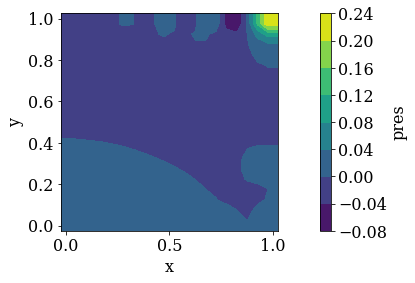

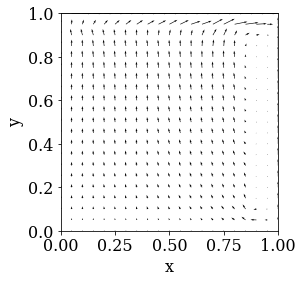

In [4]:
# Plot the analytical solution
mae6225.io.plot_contour(gridc, 'pres')
mae6225.io.plot_vector(gridx,gridy,'velc')